In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


import shap



In [2]:
# # Ridge Regression Best Params: {'model__alpha': 10.0}
# # Random Forest Best Params: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
# # XGBoost Best Params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300, 'model__subsample': 1.0}

In [2]:
def load_preprocess_data(filepath):
    
    """
    Loads and preprocesses the data from a CSV file.
    
    Args:
    filepath (str): The path to the CSV file.

    Returns:
    DataFrame: The preprocessed data.
    """
    
    # Load data from a CSV file
    df = pd.read_csv(filepath)
    # Drop irrelevant features from the dataset
    
    df.drop([ "type", "seniority", "seniorityAsMonths", "civilityTitle", "civilityGenderId", "country","countryCode",'identifierHash', 'hasIosApp','hasAndroidApp'], axis=1, inplace=True)
    # Convert language into dummy variables
    df = pd.get_dummies(df, columns=['language', 'gender', 'hasProfilePicture', 'hasAnyApp'], drop_first=True)
    
    
   

    # Convert 'seniorityAsYears' into days
    df['seniorityInDays'] = df['seniorityAsYears'] * 365
    df.drop('seniorityAsYears', axis=1, inplace=True)
  
    
    
    
   
    return df

In [42]:
# WITH FULL PARAMETERS FOR GRID
def train_evaluate_models( X_train_val, X_test, y_train_val, y_test, key):
    """
    Trains and evaluates Ridge, Random Forest, and XGBoost models.
    Performs grid search to find the best hyperparameters based on the validation set,
    then re-trains the best model on the combined train and validation sets,
    and evaluates on the test set.

    Args:
    X, y (DataFrame, Series): Full dataset and labels.

    Returns:
    dict: Contains models, their hyperparameters, and MAE scores.
    """

    # Split the data into train+validation and test sets
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

    # Set up the models and parameters for GridSearchCV
    models = {
        'Ridge': {
            'pipeline': Pipeline([('model', Ridge(random_state=42))]),
            'params': {'model__alpha':  [0.1, 1.0, 10.0]}
        },
        'Random Forest': {
            'pipeline': Pipeline([('model', RandomForestRegressor(n_jobs = -1, random_state=42))]),
            'params': {
                'model__n_estimators': [100, 200],
                'model__max_depth': [10, 20, 30],
                'model__min_samples_leaf': [1, 2],
                'model__min_samples_split': [2, 5]
            }
        },
        'XGBoost': {
            'pipeline': Pipeline([('model', XGBRegressor(n_jobs = -1, random_state=42))]),
            'params': {
                'model__n_estimators': [100, 300], 
                'model__max_depth': [3, 5],
                'model__learning_rate': [0.01, 0.1],
                'model__subsample': [0.5, 1.0],
                'model__colsample_bytree': [0.5, 1.0]
            }
        }
    }

    results = {}

    # Iterate over models, perform Grid Search, and evaluate
    for model_name, config in models.items():
        grid_search = GridSearchCV(config['pipeline'], config['params'], cv=5, scoring='neg_mean_absolute_error')
        grid_search.fit(X_train, y_train)

        # Evaluate on the validation set
        y_val_pred = grid_search.predict(X_val)
        val_mae = mean_absolute_error(y_val, y_val_pred)

        # Re-train model on the combined training and validation set
        best_model = grid_search.best_estimator_
        best_model.fit(X_train_val, y_train_val)
        

        # Final evaluation on the test set
        y_test_pred = best_model.predict(X_test)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        if model_name == 'Ridge':
            ridge_mae = mean_absolute_error(y_test, y_test_pred)
        elif model_name == "Random Forest":
            rfr_mae = mean_absolute_error(y_test, y_test_pred)
            if key:
            # SHAP values for Random Forest
                explainer_rfr  = shap.TreeExplainer(best_model.named_steps['model'], X_train)
                
        else: 
            xgb_mae = mean_absolute_error(y_test, y_test_pred)
            if key:
                explainer_xgb = shap.TreeExplainer(best_model.named_steps['model'], X_train)
                
            
        
        

        # Store results
        results[model_name] = {
            'Best Model': best_model,
            'Best Params': grid_search.best_params_,
            'Validation MAE': val_mae,
            'Test MAE': test_mae
        }

        # Print results for each model
        print(f"{model_name} - Best Params: {grid_search.best_params_}, Validation MAE: {val_mae}, Test MAE: {test_mae}")
    
    
        
    if key:  
        return  ridge_mae, rfr_mae, xgb_mae, explainer_rfr,  explainer_xgb
    else:
        return ridge_mae, rfr_mae, xgb_mae



In [7]:
def smote_regression_nonzero(X, y, k_neighbors=5, oversample_rate=0.2, random_state=None):
    """
    Perform SMOTE for regression on non-zero target values to balance the dataset.
    
    Args:
    X (DataFrame): Feature matrix.
    y (Series): Target variable.
    k_neighbors (int): Number of nearest neighbors to use.
    oversample_rate (float): Proportion of synthetic samples to generate relative to non-zero samples.
    random_state (int): Seed for the random number generator.
    
    Returns:
    DataFrame, Series: The resampled feature matrix and target variable.
    """
    if random_state:
        np.random.seed(random_state)
    
    # Select only non-zero entries from X and y
    non_zero_indices = y > 0
    X_non_zero = X[non_zero_indices]
    y_non_zero = y[non_zero_indices]
    
    
    nn = NearestNeighbors(n_neighbors=k_neighbors + 1)
    nn.fit(X_non_zero)
    neigh_dist, neigh_ind = nn.kneighbors(X_non_zero)
    
    # Drop the first neighbor since it is the point itself
    neigh_ind = neigh_ind[:, 1:]
    
    # Calculate the number of synthetic samples to create, based on the non-zero entries
    synthetic_sample_count = int(len(X_non_zero) * oversample_rate)
    
    synthetic_samples = []
    synthetic_targets = []
    
    for _ in range(synthetic_sample_count):
        # Randomly pick a non-zero index to use for creating a synthetic sample
        idx = np.random.randint(0, len(X_non_zero))
        nn_idx = np.random.choice(neigh_ind[idx], 1)[0]
        
        # Calculate the difference between the selected point and its neighbor
        diff = X_non_zero.iloc[nn_idx] - X_non_zero.iloc[idx]
        new_sample = X_non_zero.iloc[idx] + np.random.rand() * diff
        new_target = y_non_zero.iloc[idx] + np.random.rand() * (y_non_zero.iloc[nn_idx] - y_non_zero.iloc[idx])
        
        # Round to the nearest integer 
        new_target = max(1, np.round(new_target).astype(int))
        
        synthetic_samples.append(new_sample)
        synthetic_targets.append(new_target)
    
    # Combine synthetic samples with non-zero entries
    X_synthetic = pd.DataFrame(synthetic_samples, columns=X_non_zero.columns)
    y_synthetic = pd.Series(synthetic_targets, name=y_non_zero.name)
    
    X_resampled = pd.concat([X_non_zero, X_synthetic], ignore_index=True)
    y_resampled = pd.concat([y_non_zero, y_synthetic], ignore_index=True)
    
    # Combine the resampled non-zero data with the original zero entries
    X_final = pd.concat([X[~non_zero_indices], X_resampled], ignore_index=True)
    y_final = pd.concat([y[~non_zero_indices], y_resampled], ignore_index=True)
    
    return X_final, y_final


def iterative_smote_regression_nonzero(X, y, k_neighbors=5, target_ratio=0.5, max_iterations=10, random_state=None):
    """
    Apply SMOTE iteratively until the proportion of non-zero outcomes meets the target ratio or maximum iterations are reached.
    
    Args:
    X (DataFrame): Feature matrix.
    y (Series): Target variable.
    k_neighbors (int): Number of nearest neighbors.
    target_ratio (float): Desired proportion of non-zero outcomes.
    max_iterations (int): Maximum number of iterations to perform.
    random_state (int): Seed for the random number generator.
    
    Returns:
    DataFrame, Series: The feature matrix and target variable after resampling.
    """
    if random_state:
        np.random.seed(random_state)
    
    # Calculate the initial ratio of non-zero outcomes
    current_ratio = y[y > 0].size / y.size
    iteration = 0

    # Continue resampling until the target ratio or max iterations is reached
    while current_ratio < target_ratio and iteration < max_iterations:
        # Resample using the provided smote_regression_nonzero function
        X, y = smote_regression_nonzero(X, y, k_neighbors=k_neighbors, oversample_rate=1.0, random_state=random_state)
        current_ratio = y[y > 0].size / y.size
        iteration += 1
        print(f"Iteration {iteration}: Non-zero ratio {current_ratio}")
    return X,y

In [39]:
# Load the dataset from my local path
df = load_preprocess_data("/Users/angeloszois/Desktop/Thesis/6M-0K-99K.users.dataset.public.csv")
X = df.drop(['productsSold', "socialNbFollowers", "socialNbFollows", "socialProductsLiked"], axis=1)
y = df['productsSold']


In [40]:
#WITHOUT SMOTE
#WITHOUT SOCIAL
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ridge_without_mae_without, rfr_without_mae_without, xgb_without_mae_without= train_evaluate_models(X_train_val, X_test, y_train_val, y_test, key = False)
print("MAE scores:", "Ridge", ridge_without_mae_without, "RFR", rfr_without_mae_without, "XGB", xgb_without_mae_without)

Ridge - Best Params: {'model__alpha': 10.0}, Validation MAE: 0.12679476728054237, Test MAE: 0.10336448151685015
Random Forest - Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}, Validation MAE: 0.0920061992630762, Test MAE: 0.07547041226656467
XGBoost - Best Params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.5}, Validation MAE: 0.0937338984663056, Test MAE: 0.07988470140802215
MAE scores: Ridge 0.10336448151685015 RFR 0.07547041226656467 XGB 0.07988470140802215


Iteration 1: Non-zero ratio 0.04070616782628073
Iteration 2: Non-zero ratio 0.07822797459018344
Iteration 3: Non-zero ratio 0.1451047022220261
Iteration 4: Non-zero ratio 0.25343482031024184
Iteration 5: Non-zero ratio 0.4043845219610436
        productsSold
count  130094.000000
mean        2.404654
std         8.397408
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       174.000000


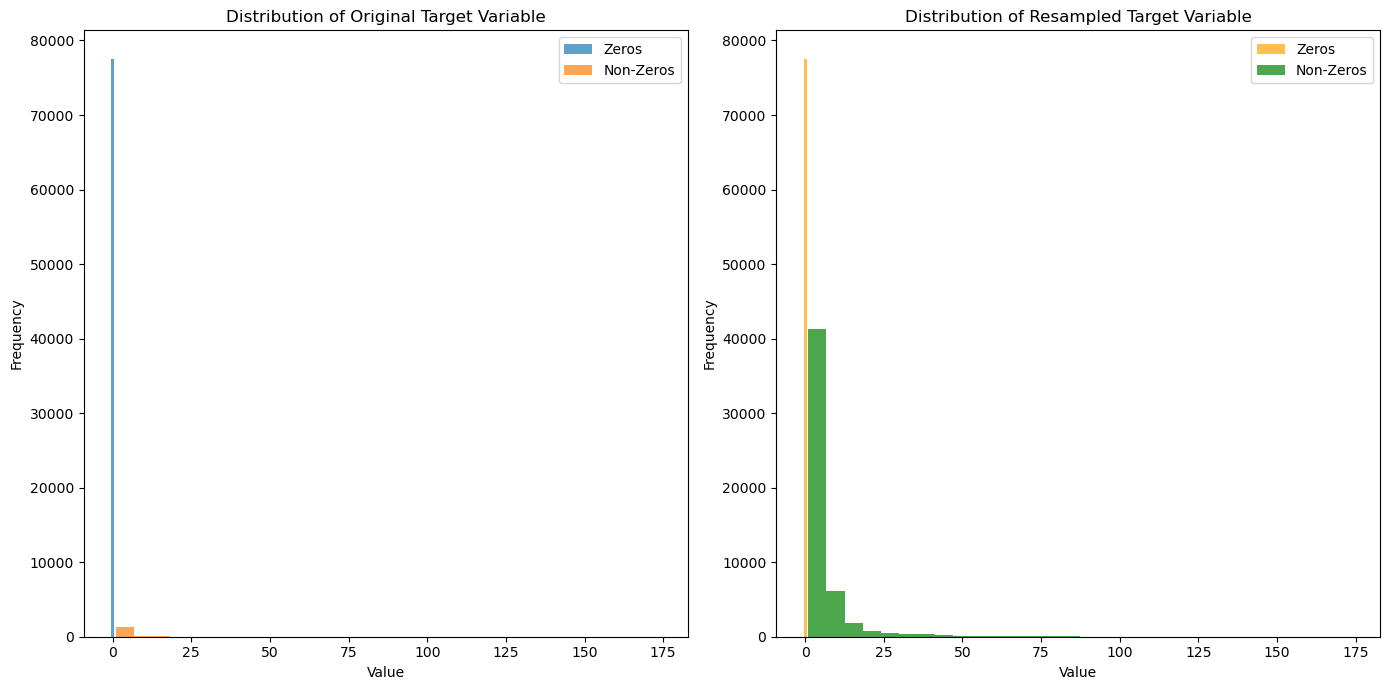

Number of non-zero entries before the resampled dataset: 1644
Number of zero entries before the resampled dataset: 77486
Number of non-zero entries in the resampled dataset: 52608
Number of zero entries in the resampled dataset: 77486
Results without social features
Ridge - Best Params: {'model__alpha': 10.0}, Validation MAE: 1.7028528895291095, Test MAE: 0.4439828941491006
Random Forest - Best Params: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}, Validation MAE: 0.3395168286767024, Test MAE: 0.09849307833083734
XGBoost - Best Params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300, 'model__subsample': 1.0}, Validation MAE: 0.5763271579887755, Test MAE: 0.13413500115479499
MAE scores: Ridge 0.4439828941491006 RFR 0.09849307833083734 XGB 0.13413500115479499


In [43]:
#WITH SMOTE
#WITHOUT SOCIAL 
# Splitting the data into training and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Resampling the training data using the functions created

X_resampled, y_resampled = iterative_smote_regression_nonzero(X_train_val, y_train_val, k_neighbors=5, target_ratio=0.4, max_iterations=10, random_state=42)
df_original = pd.DataFrame(y_train_val, columns=['productsSold'])
df_resampled = pd.DataFrame(y_resampled, columns=['productsSold'])

print(df_resampled.describe())
# Plotting the distribution before and after resampling
plt.figure(figsize=(14,7))

# Original data histogram
plt.subplot(1, 2, 1)
plt.hist(y_train_val[y_train_val == 0], bins=1, alpha=0.7, label='Zeros')
plt.hist(y_train_val[y_train_val > 0], bins=30, alpha=0.7, label='Non-Zeros')
plt.title('Distribution of Original Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Resampled data histogram
plt.subplot(1, 2, 2)
plt.hist(y_resampled[y_resampled == 0], bins=1, alpha=0.7, color='orange', label='Zeros')
plt.hist(y_resampled[y_resampled > 0], bins=30, alpha=0.7, color='green', label='Non-Zeros')
plt.title('Distribution of Resampled Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

non_zero_count = (y_resampled > 0).sum()
zero_count = (y_resampled == 0).sum()
non_zero_b_count = (y_train_val > 0).sum()
zero_b_count = (y_train_val == 0).sum()
print(f"Number of non-zero entries before the resampled dataset: {non_zero_b_count}")
print(f"Number of zero entries before the resampled dataset: {zero_b_count}")
print(f"Number of non-zero entries in the resampled dataset: {non_zero_count}")
print(f"Number of zero entries in the resampled dataset: {zero_count}")
#Calculating the results excluding the social features
print("Results without social features")   

ridge_without_mae, rfr_without_mae, xgb_without_mae= train_evaluate_models(X_resampled, X_test, y_resampled, y_test, key = False)
print("MAE scores:", "Ridge", ridge_without_mae, "RFR", rfr_without_mae, "XGB", xgb_without_mae)





In [44]:
#WITH SMOTE
#WITH SOCIAL
X1 =df.drop(['productsSold'], axis=1)
y1 = df['productsSold']

#Splitting the data into training and testing sets
X1_train_val, X1_test, y1_train_val, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

#Resampling the training data using the functions created
X1_resampled, y1_resampled = iterative_smote_regression_nonzero(X1_train_val, y1_train_val, k_neighbors=5, target_ratio=0.40, max_iterations=10, random_state=42)


#Calculating the results including the social features
print("Results with social features")
ridge_with_mae, rfr_with_mae, xgb_with_mae, explainer_rfr,  explainer_xgb= train_evaluate_models(X1_resampled, X1_test, y1_resampled, y1_test, key = True)
print("MAE scores:", "Ridge", ridge_with_mae, "RFR", rfr_with_mae, "XGB", xgb_with_mae)

Iteration 1: Non-zero ratio 0.04070616782628073
Iteration 2: Non-zero ratio 0.07822797459018344
Iteration 3: Non-zero ratio 0.1451047022220261
Iteration 4: Non-zero ratio 0.25343482031024184
Iteration 5: Non-zero ratio 0.4043845219610436
Results with social features
Ridge - Best Params: {'model__alpha': 10.0}, Validation MAE: 1.6128745499838777, Test MAE: 0.5814649414705448
Random Forest - Best Params: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}, Validation MAE: 0.2629099469730519, Test MAE: 0.06695760880342708
XGBoost - Best Params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300, 'model__subsample': 1.0}, Validation MAE: 0.4335723310138752, Test MAE: 0.09469560520912923
MAE scores: Ridge 0.5814649414705448 RFR 0.06695760880342708 XGB 0.09469560520912923


In [45]:
# WITHOUT SMOTE 
# WITH SOCIAL 
X12 =df.drop(['productsSold'], axis=1)
y12 = df['productsSold']

#Splitting the data into training and testing sets
X12_train_val, X12_test, y12_train_val, y12_test = train_test_split(X1, y1, test_size=0.2, random_state=42)


#Calculating the results including the social features
print("Results with social features")
ridge_with_mae_without, rfr_with_mae_without, xgb_with_mae_without, explainer_rfr_out, explainer_xgb_out= train_evaluate_models(X12_train_val, X12_test, y12_train_val, y12_test, key = True)
print("MAE scores:", "Ridge", ridge_with_mae_without, "RFR", rfr_with_mae_without, "XGB", xgb_with_mae_without)

Results with social features
Ridge - Best Params: {'model__alpha': 10.0}, Validation MAE: 0.2704766900366344, Test MAE: 0.2550328627319272
Random Forest - Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 200}, Validation MAE: 0.07728458246664394, Test MAE: 0.06156215801336185
XGBoost - Best Params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__subsample': 0.5}, Validation MAE: 0.07796602322004799, Test MAE: 0.06013818093356771
MAE scores: Ridge 0.2550328627319272 RFR 0.06156215801336185 XGB 0.06013818093356771


100%|===================| 19781/19783 [17:01<00:00]        

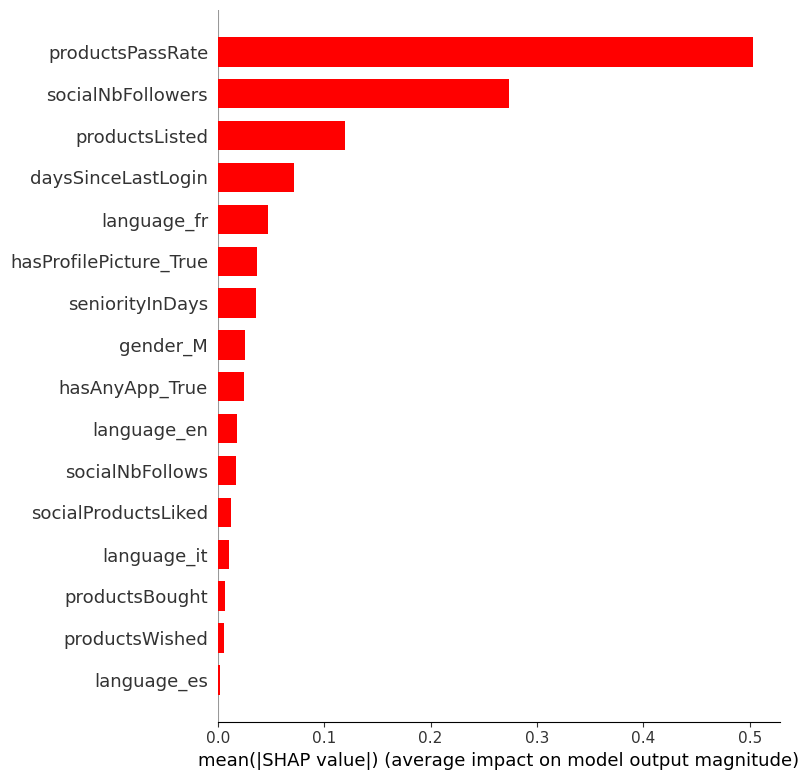

In [46]:
#Feature importance without SMOTE RFR

shap_values_rfr = explainer_rfr.shap_values(X12_test, check_additivity= False)
shap.summary_plot(shap_values_rfr, X12_test, plot_type="bar", color= 'red')

 99%|===================| 19658/19783 [01:01<00:00]        

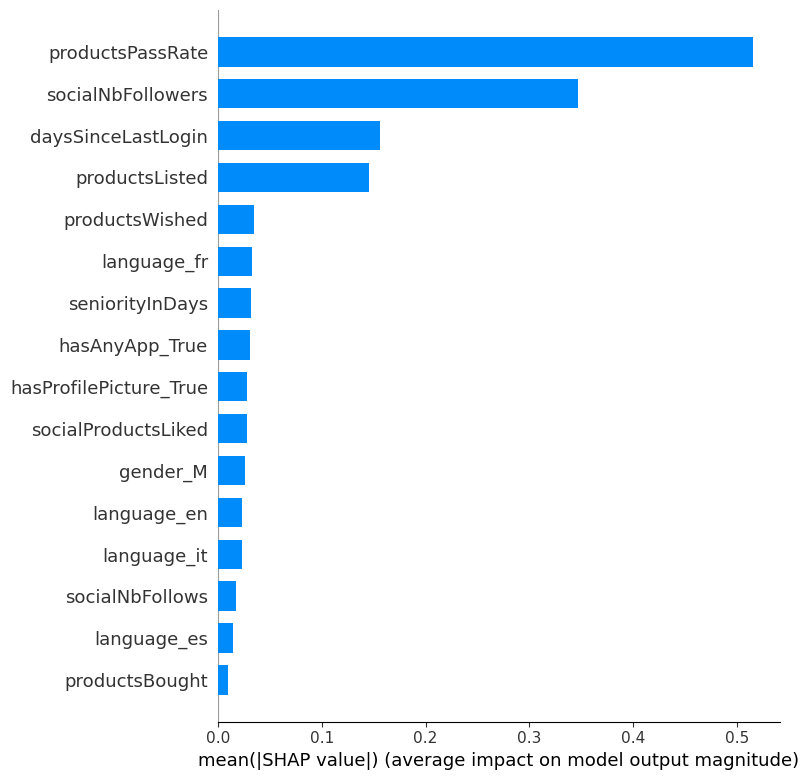

In [47]:
#Feature importance with SMOTE XGB

shap_values_xgb = explainer_xgb.shap_values(X12_test, check_additivity= False)
shap.summary_plot(shap_values_xgb, X12_test, plot_type="bar")

100%|===================| 19781/19783 [17:30<00:00]        

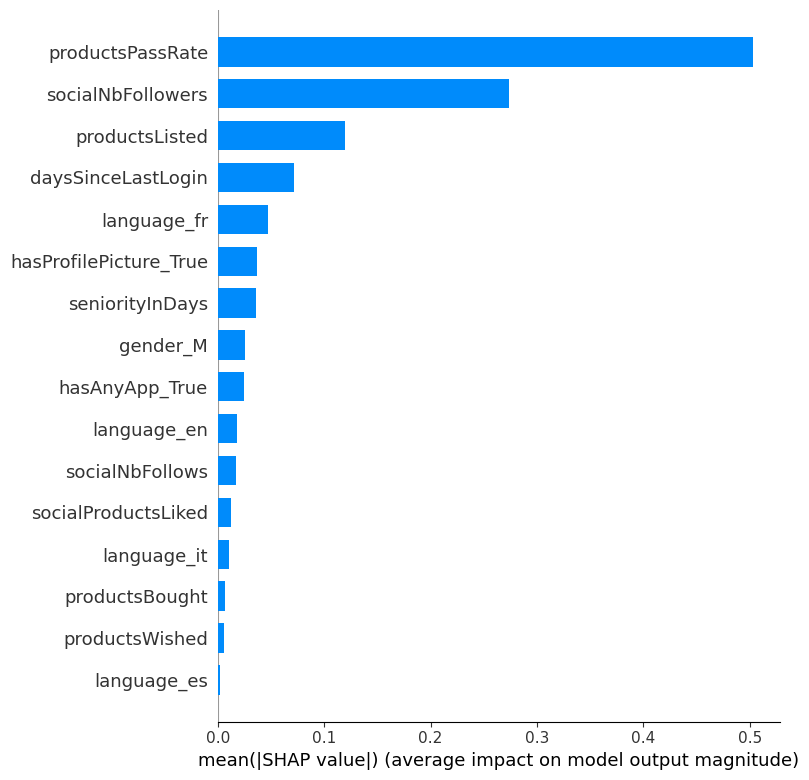

In [48]:
#Feature importance with SMOTE RFR

shap_values_rfr = explainer_rfr.shap_values(X1_test, check_additivity= False)
shap.summary_plot(shap_values_rfr, X1_test, plot_type="bar")

 99%|===================| 19682/19783 [01:01<00:00]        

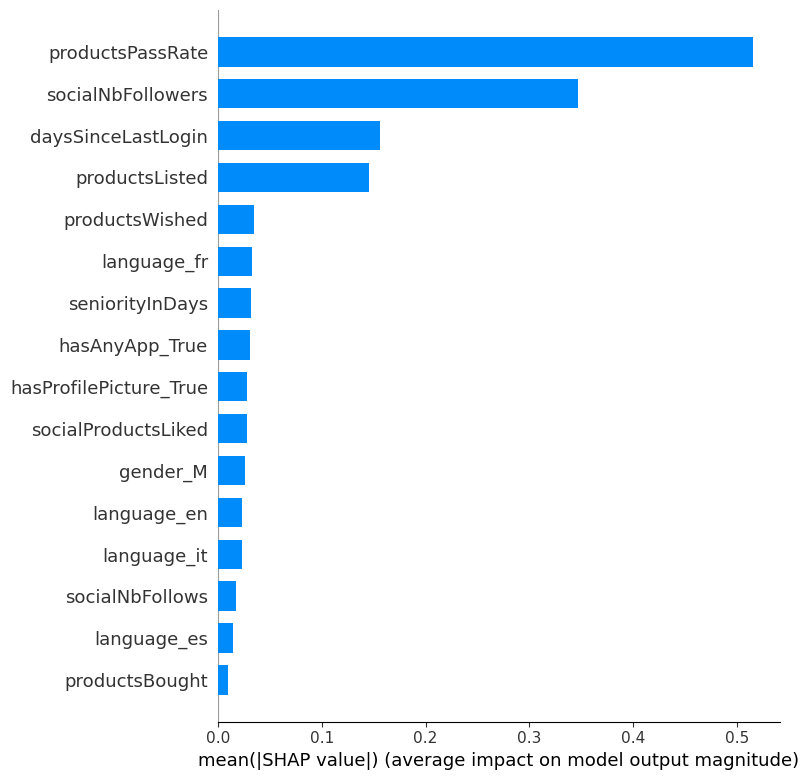

In [49]:
#Feature importance with SMOTE XGB

shap_values_xgb = explainer_xgb.shap_values(X1_test, check_additivity= False)
shap.summary_plot(shap_values_xgb, X1_test, plot_type="bar")

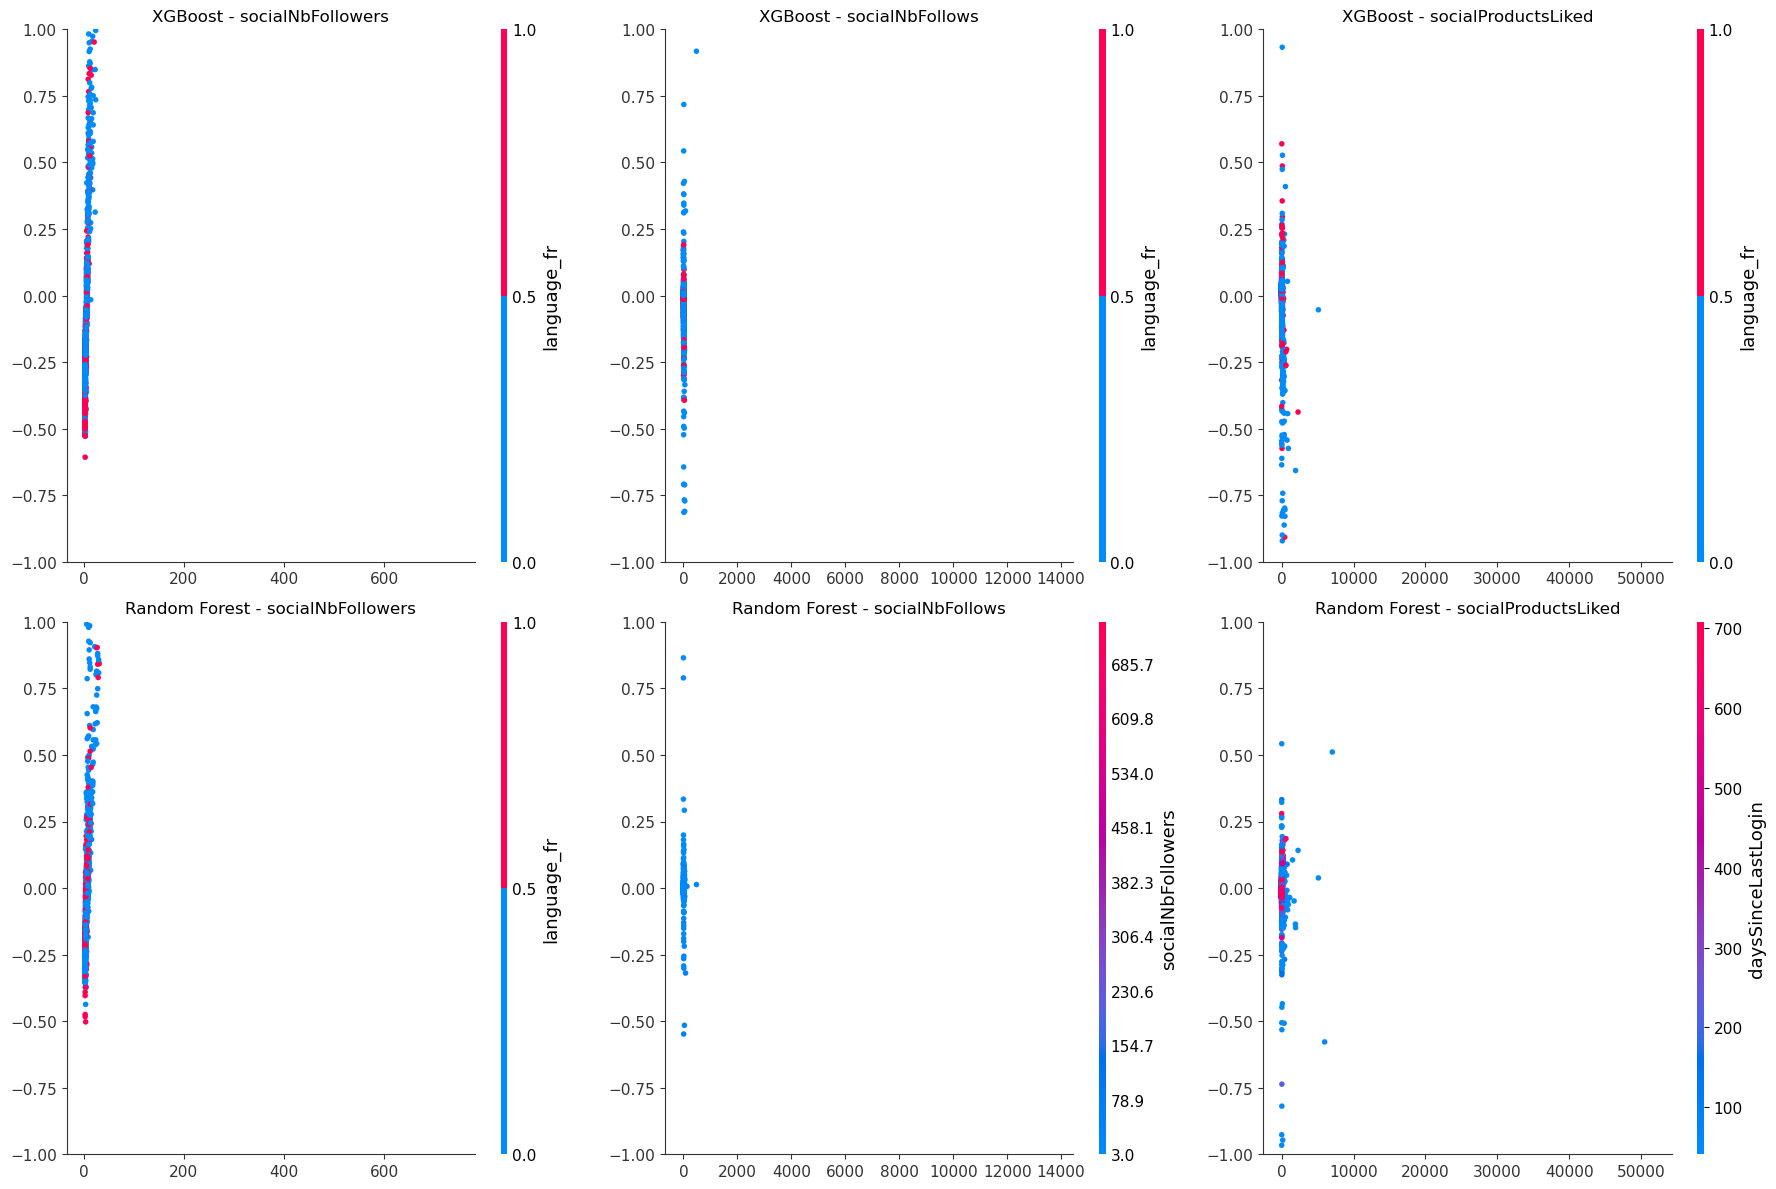

In [50]:
features =  df[["socialNbFollowers","socialNbFollows","socialProductsLiked"]]

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows for models, 3 columns for features

# Iterate over each row (model) and each column (feature)
for row_idx, (model_name, shap_values) in enumerate(zip(['XGBoost', 'Random Forest'], [shap_values_xgb, shap_values_rfr])):
    for col_idx, feature in enumerate(features):
        ax = axs[row_idx, col_idx]
        shap.dependence_plot(feature, shap_values, X1_test, ax=ax, show=False)
        ax.set_title(f'{model_name} - {feature}')

        # To handle plot labels and size issues, sometimes you need to adjust limits or layout
        ax.set_ylim([-1, 1])  # Example: set y-limits, adjust as necessary
        ax.set_xlabel('')
        ax.set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()

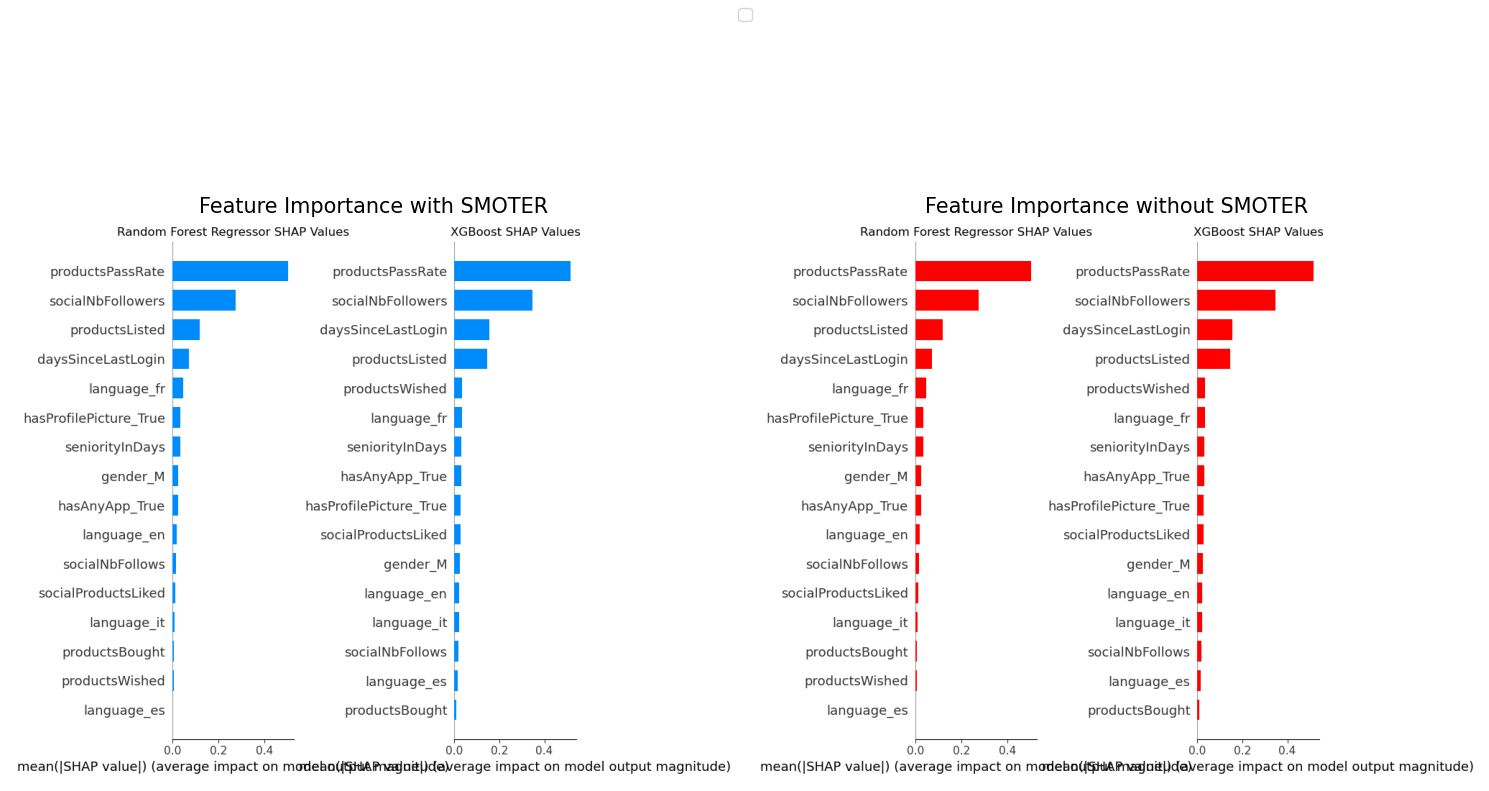

In [51]:
import matplotlib.pyplot as plt
from PIL import Image

# Load the images
img_with_smote = Image.open('shar_with_social_without_smote.png')
img_without_smote = Image.open('SHAP_RFR_XGB.png')

# Create a figure to combine the images
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# Display the images
axs[0].imshow(img_without_smote)
axs[0].axis('off')  # Hide the axes
axs[0].set_title('Feature Importance with SMOTER', fontsize=15)

axs[1].imshow(img_with_smote)
axs[1].axis('off')  # Hide the axes
axs[1].set_title('Feature Importance without SMOTER', fontsize=15)

# Add a legend for clarity
fig.legend(['Without SMOTER (Red)', 'With SMOTER (Blue)'], loc='upper center', fontsize=12)

plt.tight_layout()
plt.show()

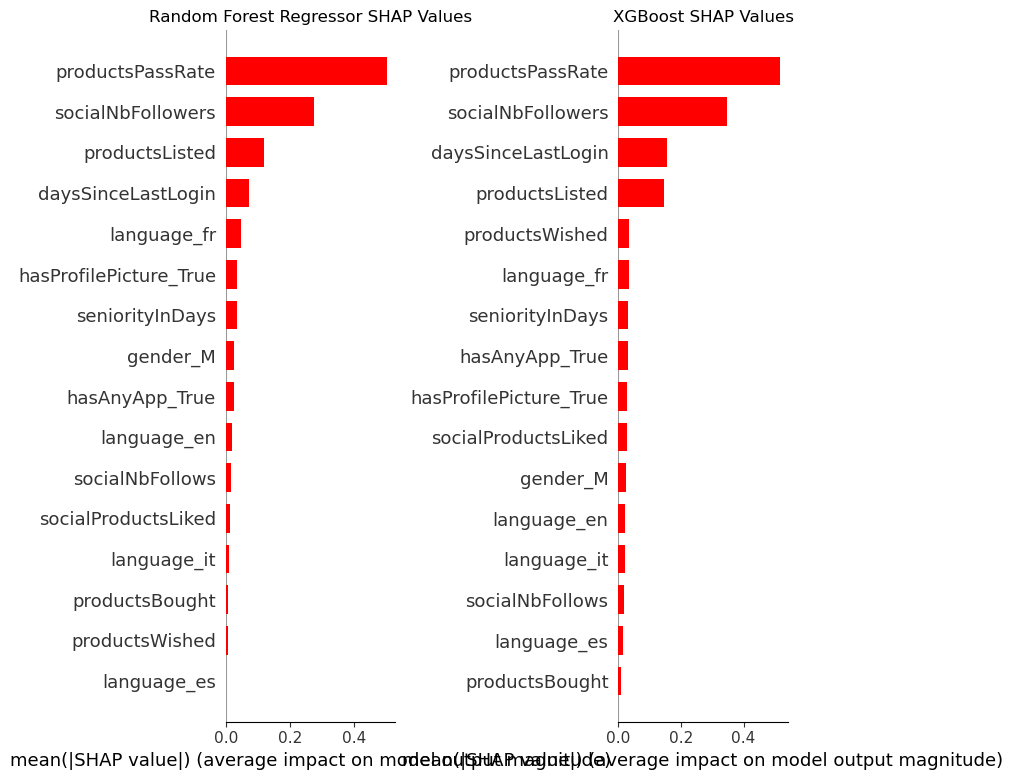

In [35]:
# Create a large enough figure to handle subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 12))

# First plot for Random Forest Regressor
plt.sca(axs[0])  # Set the current axes to axs[0]
shap.summary_plot(shap_values_rfr, X12_test, plot_type="bar", color= 'red', show=False)
axs[0].set_title('Random Forest Regressor SHAP Values')
# axs[0].tick_params(axis='y', labelrotation=45)  # Rotate labels to prevent overlap

# Second plot for XGBoost
plt.sca(axs[1])  # Set the current axes to axs[1]
shap.summary_plot(shap_values_xgb, X12_test, plot_type="bar", color = 'red', show=False)
axs[1].set_title('XGBoost SHAP Values')
# axs[1].tick_params(axis='y', labelrotation=45)  # Rotate labels to prevent overlap

plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

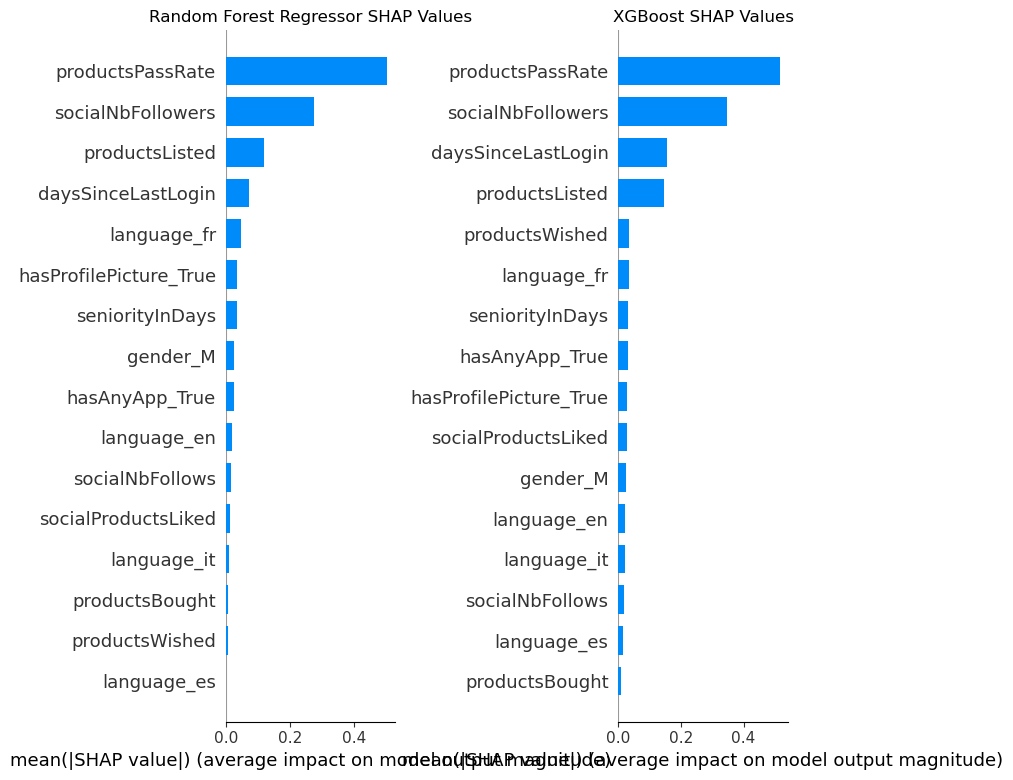

In [59]:
# Create a large enough figure to handle subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 12))

# First plot for Random Forest Regressor
plt.sca(axs[0])  # Set the current axes to axs[0]
shap.summary_plot(shap_values_rfr, X1_test, plot_type="bar", show=False)
axs[0].set_title('Random Forest Regressor SHAP Values')
# axs[0].tick_params(axis='y', labelrotation=45)  # Rotate labels to prevent overlap

# Second plot for XGBoost
plt.sca(axs[1])  # Set the current axes to axs[1]
shap.summary_plot(shap_values_xgb, X1_test, plot_type="bar", show=False)
axs[1].set_title('XGBoost SHAP Values')
# axs[1].tick_params(axis='y', labelrotation=45)  # Rotate labels to prevent overlap

plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

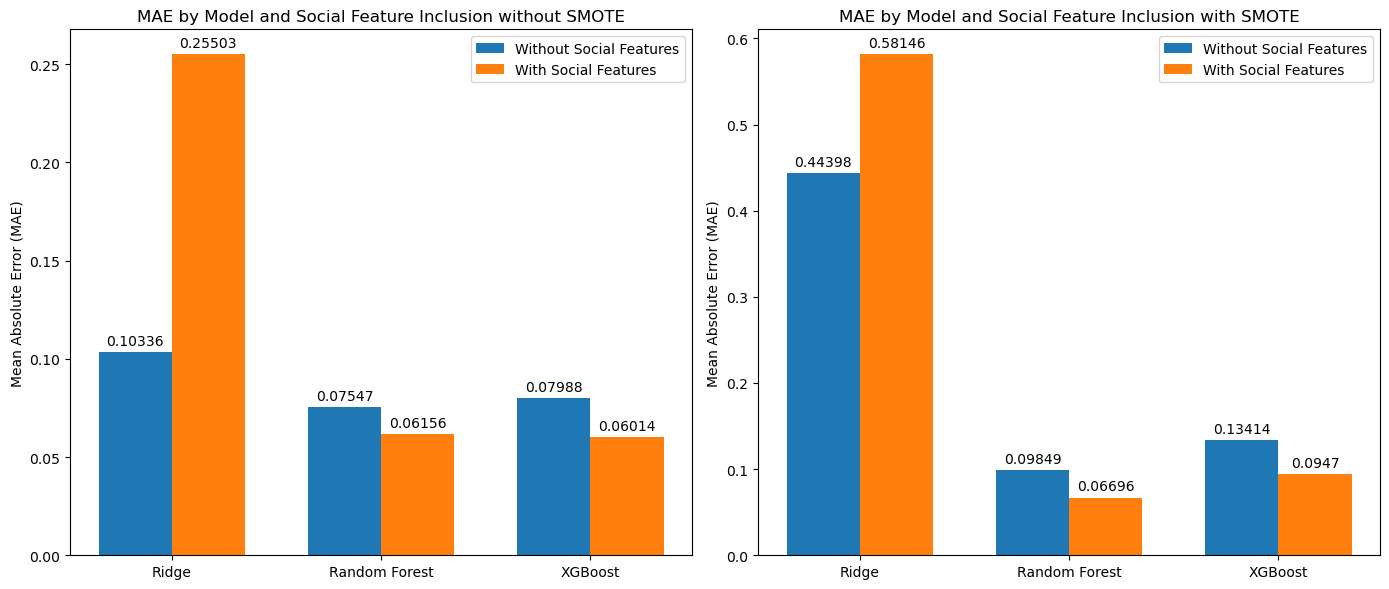

In [54]:
models = ['Ridge', 'Random Forest', 'XGBoost']
mae_without_social_without = [round(ridge_without_mae_without, 5), round(rfr_without_mae_without, 5), round(xgb_without_mae_without,5)]  
mae_with_social_without = [round(ridge_with_mae_without, 5), round(rfr_with_mae_without, 5), round(xgb_with_mae_without, 5)]  
mae_without_social = [round(ridge_without_mae, 5), round(rfr_without_mae, 5), round(xgb_without_mae,5)]  
mae_with_social = [round(ridge_with_mae, 5), round(rfr_with_mae, 5), round(xgb_with_mae, 5)]  






models = ['Ridge', 'Random Forest', 'XGBoost']  # Example model names
mae_without_social_without = [round(ridge_without_mae_without, 5), round(rfr_without_mae_without, 5), round(xgb_without_mae_without,5)]  
mae_with_social_without = [round(ridge_with_mae_without, 5), round(rfr_with_mae_without, 5), round(xgb_with_mae_without, 5)]  
mae_without_social = [round(ridge_without_mae, 5), round(rfr_without_mae, 5), round(xgb_without_mae,5)]  
mae_with_social = [round(ridge_with_mae, 5), round(rfr_with_mae, 5), round(xgb_with_mae, 5)]  

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Data setup
x = list(range(len(models)))  # model indices
width = 0.35  # width of the bars

# First subplot: Without SMOTE
rects1 = ax1.bar([i - width/2 for i in x], mae_without_social_without, width, label='Without Social Features')
rects2 = ax1.bar([i + width/2 for i in x], mae_with_social_without, width, label='With Social Features')

ax1.set_ylabel('Mean Absolute Error (MAE)')
ax1.set_title('MAE by Model and Social Feature Inclusion without SMOTE')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)

# Second subplot: With SMOTE
rects3 = ax2.bar([i - width/2 for i in x], mae_without_social, width, label='Without Social Features')
rects4 = ax2.bar([i + width/2 for i in x], mae_with_social, width, label='With Social Features')

ax2.set_ylabel('Mean Absolute Error (MAE)')
ax2.set_title('MAE by Model and Social Feature Inclusion with SMOTE')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.bar_label(rects3, padding=3)
ax2.bar_label(rects4, padding=3)

plt.tight_layout()
plt.show()



